In [1]:
%pip install numpy pandas scikit-learn seaborn matplotlib xgboost deap --quiet

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 25.0
[notice] To update, run: python.exe -m pip install --upgrade pip


# Comparative Study Between Ensemble Learning and Evolutionary Learning to solve the Higgs Bozon Detection

In [2]:
import time
import random
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.decomposition import PCA

import xgboost as xgb
from deap import base, creator, tools, algorithms

import matplotlib.pyplot as plt

## Data loading

In [3]:
dataFilename = './atlas-higgs.csv'
data = pd.read_csv(dataFilename)

print(data.shape)
print(data.dtypes)

(818238, 35)
EventId                          int64
DER_mass_MMC                   float64
DER_mass_transverse_met_lep    float64
DER_mass_vis                   float64
DER_pt_h                       float64
DER_deltaeta_jet_jet           float64
DER_mass_jet_jet               float64
DER_prodeta_jet_jet            float64
DER_deltar_tau_lep             float64
DER_pt_tot                     float64
DER_sum_pt                     float64
DER_pt_ratio_lep_tau           float64
DER_met_phi_centrality         float64
DER_lep_eta_centrality         float64
PRI_tau_pt                     float64
PRI_tau_eta                    float64
PRI_tau_phi                    float64
PRI_lep_pt                     float64
PRI_lep_eta                    float64
PRI_lep_phi                    float64
PRI_met                        float64
PRI_met_phi                    float64
PRI_met_sumet                  float64
PRI_jet_num                      int64
PRI_jet_leading_pt             float64
PRI_jet_lead

In [4]:
data.head()

,EventId,DER_mass_MMC,DER_mass_transverse_met_lep,DER_mass_vis,DER_pt_h,DER_deltaeta_jet_jet,DER_mass_jet_jet,DER_prodeta_jet_jet,DER_deltar_tau_lep,DER_pt_tot,...,PRI_jet_leading_eta,PRI_jet_leading_phi,PRI_jet_subleading_pt,PRI_jet_subleading_eta,PRI_jet_subleading_phi,PRI_jet_all_pt,Weight,Label,KaggleSet,KaggleWeight
0,100000,138.470,51.655,97.827,27.980,0.91,124.711,2.666,3.064,41.928,...,2.150,0.444,46.062,1.24,-2.475,113.497,0.000814,s,t,0.002653
1,100001,160.937,68.768,103.235,48.146,-999.00,-999.000,-999.000,3.473,2.078,...,0.725,1.158,-999.000,-999.00,-999.000,46.226,0.681042,b,t,2.233584
2,100002,-999.000,162.172,125.953,35.635,-999.00,-999.000,-999.000,3.148,9.336,...,2.053,-2.028,-999.000,-999.00,-999.000,44.251,0.715742,b,t,2.347389
3,100003,143.905,81.417,80.943,0.414,-999.00,-999.000,-999.000,3.310,0.414,...,-999.000,-999.000,-999.000,-999.00,-999.000,-0.000,1.660654,b,t,5.446378
4,100004,175.864,16.915,134.805,16.405,-999.00,-999.000,-999.000,3.891,16.405,...,-999.000,-999.000,-999.000,-999.00,-999.000,0.000,1.904263,b,t,6.245333


## Data cleaning

In [5]:
del(data['EventId'])
del(data['Weight'])
del(data['KaggleSet'])
del(data['KaggleWeight'])

Encoder = LabelEncoder()

data['Label'] = Encoder.fit_transform(data['Label'])

data

,DER_mass_MMC,DER_mass_transverse_met_lep,DER_mass_vis,DER_pt_h,DER_deltaeta_jet_jet,DER_mass_jet_jet,DER_prodeta_jet_jet,DER_deltar_tau_lep,DER_pt_tot,DER_sum_pt,...,PRI_met_sumet,PRI_jet_num,PRI_jet_leading_pt,PRI_jet_leading_eta,PRI_jet_leading_phi,PRI_jet_subleading_pt,PRI_jet_subleading_eta,PRI_jet_subleading_phi,PRI_jet_all_pt,Label
0,138.470,51.655,97.827,27.980,0.910,124.711,2.666,3.064,41.928,197.760,...,258.733,2,67.435,2.150,0.444,46.062,1.240,-2.475,113.497,1
1,160.937,68.768,103.235,48.146,-999.000,-999.000,-999.000,3.473,2.078,125.157,...,164.546,1,46.226,0.725,1.158,-999.000,-999.000,-999.000,46.226,0
2,-999.000,162.172,125.953,35.635,-999.000,-999.000,-999.000,3.148,9.336,197.814,...,260.414,1,44.251,2.053,-2.028,-999.000,-999.000,-999.000,44.251,0
3,143.905,81.417,80.943,0.414,-999.000,-999.000,-999.000,3.310,0.414,75.968,...,86.062,0,-999.000,-999.000,-999.000,-999.000,-999.000,-999.000,-0.000,0
4,175.864,16.915,134.805,16.405,-999.000,-999.000,-999.000,3.891,16.405,57.983,...,53.131,0,-999.000,-999.000,-999.000,-999.000,-999.000,-999.000,0.000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
818233,105.668,46.443,60.048,156.191,0.403,47.746,0.936,1.279,6.133,256.853,...,303.668,2,112.264,1.190,-0.766,41.791,0.787,-1.090,154.056,1
818234,99.294,30.097,62.713,65.861,3.312,471.319,-2.611,2.294,2.889,248.582,...,266.919,2,108.698,1.293,-0.868,70.158,-2.018,2.893,178.856,1
818235,108.497,9.837,65.149,18.006,-999.000,-999.000,-999.000,2.742,18.006,68.097,...,188.648,0,-999.000,-999.000,-999.000,-999.000,-999.000,-999.000,-0.000,0
818236,96.711,20.006,66.942,29.761,-999.000,-999.000,-999.000,2.479,2.739,101.676,...,212.565,1,30.863,1.460,2.637,-999.000,-999.000,-999.000,30.863,0


## Handling missing values

Missing data in this file are designated -999.

In [7]:
imputer = SimpleImputer(missing_values=-999, strategy='mean')

columns = data.columns
numeric_cols = data.select_dtypes(include=['float64', 'int64']).columns

data[numeric_cols] = imputer.fit_transform(data[numeric_cols])

data

,DER_mass_MMC,DER_mass_transverse_met_lep,DER_mass_vis,DER_pt_h,DER_deltaeta_jet_jet,DER_mass_jet_jet,DER_prodeta_jet_jet,DER_deltar_tau_lep,DER_pt_tot,DER_sum_pt,...,PRI_met_sumet,PRI_jet_num,PRI_jet_leading_pt,PRI_jet_leading_eta,PRI_jet_leading_phi,PRI_jet_subleading_pt,PRI_jet_subleading_eta,PRI_jet_subleading_phi,PRI_jet_all_pt,Label
0,138.470000,51.655,97.827,27.980,0.910000,124.71100,2.66600,3.064,41.928,197.760,...,258.733,2.0,67.435000,2.150000,0.444000,46.062000,1.240000,-2.47500,113.497,1.0
1,160.937000,68.768,103.235,48.146,2.404626,372.18105,-0.82874,3.473,2.078,125.157,...,164.546,1.0,46.226000,0.725000,1.158000,57.810286,-0.006669,-0.01047,46.226,0.0
2,121.867697,162.172,125.953,35.635,2.404626,372.18105,-0.82874,3.148,9.336,197.814,...,260.414,1.0,44.251000,2.053000,-2.028000,57.810286,-0.006669,-0.01047,44.251,0.0
3,143.905000,81.417,80.943,0.414,2.404626,372.18105,-0.82874,3.310,0.414,75.968,...,86.062,0.0,84.904285,-0.001248,-0.018856,57.810286,-0.006669,-0.01047,-0.000,0.0
4,175.864000,16.915,134.805,16.405,2.404626,372.18105,-0.82874,3.891,16.405,57.983,...,53.131,0.0,84.904285,-0.001248,-0.018856,57.810286,-0.006669,-0.01047,0.000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
818233,105.668000,46.443,60.048,156.191,0.403000,47.74600,0.93600,1.279,6.133,256.853,...,303.668,2.0,112.264000,1.190000,-0.766000,41.791000,0.787000,-1.09000,154.056,1.0
818234,99.294000,30.097,62.713,65.861,3.312000,471.31900,-2.61100,2.294,2.889,248.582,...,266.919,2.0,108.698000,1.293000,-0.868000,70.158000,-2.018000,2.89300,178.856,1.0
818235,108.497000,9.837,65.149,18.006,2.404626,372.18105,-0.82874,2.742,18.006,68.097,...,188.648,0.0,84.904285,-0.001248,-0.018856,57.810286,-0.006669,-0.01047,-0.000,0.0
818236,96.711000,20.006,66.942,29.761,2.404626,372.18105,-0.82874,2.479,2.739,101.676,...,212.565,1.0,30.863000,1.460000,2.637000,57.810286,-0.006669,-0.01047,30.863,0.0


## Data calibration

In [9]:
scaler = MinMaxScaler()

data[numeric_cols] = scaler.fit_transform(data[numeric_cols])

data

,DER_mass_MMC,DER_mass_transverse_met_lep,DER_mass_vis,DER_pt_h,DER_deltaeta_jet_jet,DER_mass_jet_jet,DER_prodeta_jet_jet,DER_deltar_tau_lep,DER_pt_tot,DER_sum_pt,...,PRI_met_sumet,PRI_jet_num,PRI_jet_leading_pt,PRI_jet_leading_eta,PRI_jet_leading_phi,PRI_jet_subleading_pt,PRI_jet_subleading_eta,PRI_jet_subleading_phi,PRI_jet_all_pt,Label
0,0.066707,0.053326,0.068128,0.009869,0.104310,0.022395,0.591293,0.515244,0.014789,0.074595,...,0.112586,0.666667,0.033028,0.738889,0.570656,0.020388,0.637778,0.106143,0.061014,1.0
1,0.078287,0.070992,0.072155,0.016983,0.275633,0.072274,0.495970,0.589031,0.000733,0.038884,...,0.069314,0.333333,0.014316,0.580556,0.684278,0.035301,0.499259,0.498334,0.024850,0.0
2,0.058150,0.167417,0.089071,0.012570,0.275633,0.072274,0.495970,0.530399,0.003293,0.074622,...,0.113359,0.333333,0.012573,0.728111,0.177276,0.035301,0.499259,0.498334,0.023789,0.0
3,0.069508,0.084050,0.055557,0.000146,0.275633,0.072274,0.495970,0.559625,0.000146,0.014690,...,0.033256,0.000000,0.048440,0.499861,0.496999,0.035301,0.499259,0.498334,0.000000,0.0
4,0.085980,0.017462,0.095662,0.005787,0.275633,0.072274,0.495970,0.664442,0.005787,0.005843,...,0.018126,0.000000,0.048440,0.499861,0.496999,0.035301,0.499259,0.498334,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
818233,0.049801,0.047945,0.039999,0.055094,0.046194,0.006882,0.544106,0.193217,0.002163,0.103662,...,0.133231,0.666667,0.072579,0.632222,0.378103,0.014967,0.587444,0.326544,0.082818,1.0
818234,0.046515,0.031070,0.041983,0.023231,0.379642,0.092256,0.447357,0.376331,0.001019,0.099593,...,0.116347,0.666667,0.069433,0.643667,0.361871,0.050975,0.275778,0.960376,0.096150,1.0
818235,0.051259,0.010155,0.043797,0.006351,0.275633,0.072274,0.495970,0.457153,0.006351,0.010818,...,0.080387,0.000000,0.048440,0.499861,0.496999,0.035301,0.499259,0.498334,0.000000,0.0
818236,0.045184,0.020653,0.045132,0.010498,0.275633,0.072274,0.495970,0.409706,0.000966,0.027335,...,0.091375,0.333333,0.000761,0.662222,0.919637,0.035301,0.499259,0.498334,0.016591,0.0


## Class distribution

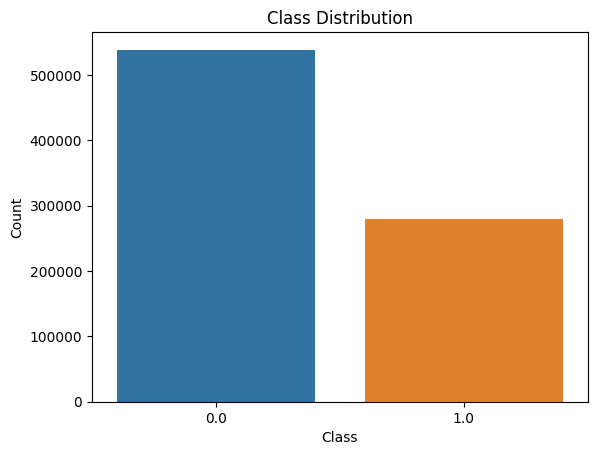

In [10]:
sns.countplot(data=data, x='Label', hue='Label', dodge=False, legend=False)
plt.title("Class Distribution")
plt.xlabel("Class")
plt.ylabel("Count")
plt.show()

## Dimensionality reduction

In [11]:
pca = PCA(n_components = 0.90)

data_reduced = pca.fit_transform(data)

print(f"Original shape: {data.shape}")
print(f"Reduced shape: {data_reduced.shape}")

Original shape: (818238, 31)
Reduced shape: (818238, 10)


## Data splitting

In [12]:
from sklearn.model_selection import train_test_split
import pandas as pd

data = pd.DataFrame(data, columns=columns)

x = data_reduced
y = data["Label"]

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.30, random_state=42)

print(X_train.shape,X_test.shape,y_train.shape,y_test.shape)

(572766, 10) (245472, 10) (572766,) (245472,)


## Ensemble Learning

### Bagging: Random Forest

In [15]:
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, criterion='gini', min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features='sqrt', min_impurity_decrease=0.0, verbose=0, ccp_alpha=0.0)

deb = time.time()
rf_model.fit(X_train, y_train)
fin = time.time()

y_pred_rf = rf_model.predict(X_test)
time_rf = fin-deb
print("Time taken:", time_rf)

accuracy_rf = accuracy_score(y_test, y_pred_rf)
precision_rf = precision_score(y_test, y_pred_rf)
recall_rf = recall_score(y_test, y_pred_rf)
f1_rf = f1_score(y_test, y_pred_rf)

print(f"Random Forest - Accuracy: {accuracy_rf}, Precision: {precision_rf}, Recall: {recall_rf}, F1-Score: {f1_rf}")

Time taken: 136.95007252693176
Random Forest - Accuracy: 1.0, Precision: 1.0, Recall: 1.0, F1-Score: 1.0


### Boosting: XGBoost

In [16]:
xgb_model = xgb.XGBClassifier(eval_metric='mlogloss', use_label_encoder=False)

deb = time.time()
xgb_model.fit(X_train, y_train)
fin = time.time()

y_pred_xgb = xgb_model.predict(X_test)
time_xgb = fin-deb
print("Time taken:", time_xgb)

accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
precision_xgb = precision_score(y_test, y_pred_xgb)
recall_xgb = recall_score(y_test, y_pred_xgb)
f1_xgb = f1_score(y_test, y_pred_xgb)

print(f"XGBoost - Accuracy: {accuracy_xgb}, Precision: {precision_xgb}, Recall: {recall_xgb}, F1-Score: {f1_xgb}")

c:\Users\miche\Documents\Erasmus\DeVinci\Advanced ML II\venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:02:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Time taken: 0.7739958763122559
XGBoost - Accuracy: 1.0, Precision: 1.0, Recall: 1.0, F1-Score: 1.0


### 3. Evolutionary Learning Implementation with DEAP


In [ ]:
# Initialize DEAP structures
creator.create("FitnessMax", base.Fitness, weights=(1.0,))  # Maximize classification accuracy
creator.create("Individual", list, fitness=creator.FitnessMax)

# Create the primitive set (basic operations)
def evalSymbReg(individual):
    # Basic GP function: Evaluate the individual in a classifier task (acc or f1)
    model = RandomForestClassifier()
    individual = np.array(individual).reshape(-1, 1)
    X_train_sub = X_train[:, individual.astype(int).flatten()]
    X_test_sub = X_test[:, individual.astype(int).flatten()]
    model.fit(X_train_sub, y_train)
    y_pred = model.predict(X_test_sub)
    return (accuracy_score(y_test, y_pred),)

# Evolutionary algorithm functions
toolbox = base.Toolbox()
toolbox.register("attr_int", random.randint, 0, X.shape[1] - 1)  # randomly select feature
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_int, n=10)  # number of features
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

# Selection, crossover, mutation
toolbox.register("mate", tools.cxOnePoint)
toolbox.register("mutate", tools.mutShuffleIndexes, indpb=0.2)
toolbox.register("select", tools.selTournament, tournsize=3)
toolbox.register("evaluate", evalSymbReg)

# Create population
population = toolbox.population(n=50)  # Size of population

# Algorithm parameters
algorithms.eaSimple(population, toolbox, cxpb=0.5, mutpb=0.2, ngen=5, 
                    stats=None, halloffame=None, verbose=True)


KeyboardInterrupt: 

### Performance Evaluation 

In [17]:
# Performance evaluation function for all models
def evaluate_performance(model, X_train, X_test, y_train, y_test):
    start_time = time.time()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    end_time = time.time()
    
    metrics = {
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred),
        "Recall": recall_score(y_test, y_pred),
        "F1-Score": f1_score(y_test, y_pred),
        "Training Time": end_time - start_time
    }
    return metrics

# Compare performances
results = {
    "Random Forest": evaluate_performance(rf_model, X_train, X_test, y_train, y_test),
    "XGBoost": evaluate_performance(xgb_model, X_train, X_test, y_train, y_test),
    # Add evolutionary learning model results here
}

# Output results
for model_name, metrics in results.items():
    print(f"{model_name} Performance:")
    for metric, value in metrics.items():
        print(f"{metric}: {value}")
    print("\n")


KeyboardInterrupt: 

### Comparative analysis

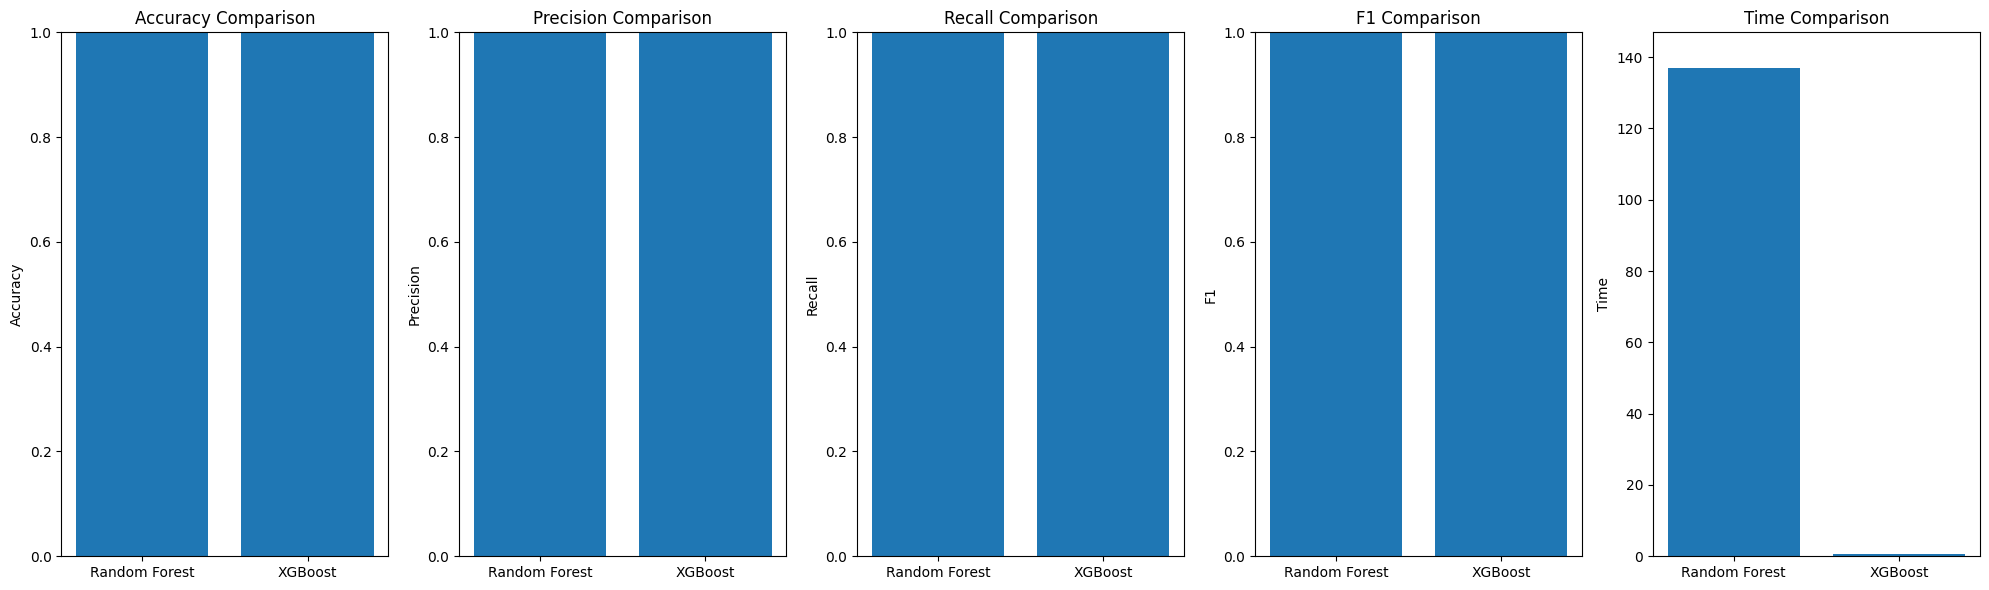

In [20]:
results = {
    "Random Forest": {"Accuracy": accuracy_rf, "Precision": precision_rf, "Recall": recall_rf, "F1": f1_rf, "Time": time_rf},
    "XGBoost": {"Accuracy": accuracy_xgb, "Precision": precision_xgb, "Recall": recall_xgb, "F1": f1_xgb, "Time": time_xgb},
    # Add evolutionary learning model results here
}

models = list(results.keys())
metrics = ["Accuracy", "Precision", "Recall", "F1", "Time"]

# Prepare the figure and axes
fig, axes = plt.subplots(1, len(metrics), figsize=(20, 6))

# For each metric, plot the values across models
for i, metric in enumerate(metrics):
    ax = axes[i]
    ax.bar(models, [results[model][metric] for model in models])
    ax.set_title(f'{metric} Comparison')
    ax.set_ylabel(metric)
    ax.set_ylim(0, 1) if metric != 'Time' else ax.set_ylim(0, max(results[model]["Time"] for model in models) + 10)

# Adjust layout to prevent overlapping of labels
plt.tight_layout()
plt.show()